In [3]:
import xarray as xr
from scipy.interpolate import griddata
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
# Using Antwerp Ghent and Charleroi as training set
# Brussels as testing set

In [7]:
cities = ['Antwerp','Charleroi','Ghent']
urbclim_and_feature_files = {}
era5_files = {}
for city in cities:
    urbclim_and_feature_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/{city}_urbclim_and_features_2015_07_01to10.csv',index_col=0)
    era5_files[city] = pd.read_csv(f'/Users/wangy/Documents/MACS/Thesis/ERA5_variables/{city}/ERA5_2015_07_01to10_{city}_Corrected.csv',index_col=0)

print(urbclim_and_feature_files)
print(era5_files)

{'Antwerp':                          time          y         x        tas  AHF_Antwerp.nc  \
0                  2015-07-01  51.101140  4.204696  21.213068        4.658679   
1                  2015-07-01  51.101210  4.206120  21.115869        4.658679   
2                  2015-07-01  51.101284  4.207544  21.071832        4.658679   
3                  2015-07-01  51.101353  4.208968  20.965753        4.061239   
4                  2015-07-01  51.101425  4.210392  20.114313        4.061239   
...                       ...        ...       ...        ...             ...   
21744235  2015-07-10 23:00:00  51.390260  4.594774  18.087183        1.723335   
21744236  2015-07-10 23:00:00  51.390324  4.596208  18.089258        1.723335   
21744237  2015-07-10 23:00:00  51.390392  4.597641  18.045221        1.723335   
21744238  2015-07-10 23:00:00  51.390457  4.599074  17.997308        1.723335   
21744239  2015-07-10 23:00:00  51.390526  4.600507  17.911432        1.723335   

          Coast

In [8]:
# Add the time feature into the df

def add_time_feature(all_variables):
    all_variables['time'] = pd.to_datetime(all_variables['time'], format='mixed')
    # Extract the hour of the day
    all_variables['hour'] = all_variables['time'].dt.hour
    # Convert time features using sin and cos
    all_variables['hour_sin'] = np.sin(2 * np.pi * all_variables['hour'] / 24)
    all_variables['hour_cos'] = np.cos(2 * np.pi * all_variables['hour'] / 24)
    
    # Extract the day of the year
    # all_variables['day_of_year'] = all_variables['time'].dt.dayofyear
    # Convert time features using sin and cos
    # df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    # df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # print(all_variables[['time', 'hour',  'hour_sin', 'hour_cos']])


In [ ]:
# Using brussels 2015.07.01-10 + time as comparation (this cell can be ignored)
urbclim_and_feature = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/Brussles_urbclim_and_features_2015_07_01to10.csv',index_col=0)
era5 = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/Brussels/ERA5_Corrected/ERA5_2015_07_01to10_Brussels_Corrected.csv',index_col=0)

era5_new = era5.drop(columns=['x','y','time','t2m'])
era5_new[['t2m_corrected']] -= 273.15
# display(era5_new.columns)
urbclim_and_feature = urbclim_and_feature.drop(columns=['Unnamed: 0', 'y.1', 'x.1'])
# display(urbclim_and_feature.columns)
all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
display(all_variables)

add_time_feature(all_variables)

all_variables.dropna(inplace=True)
all_variables.reset_index(drop=True, inplace=True)

y_train = pd.DataFrame()
# Compute the new 'tas' column
y_train['residue'] = all_variables['tas'] - all_variables['t2m_corrected']

X_train = all_variables.drop(columns=['x','y','time','tas','hour'])


In [9]:
# Add the same time features to different city df
for df in urbclim_and_feature_files.values():
    add_time_feature(df)
    

In [10]:
# This function is to combine the preprocessed urbclim data, features data and era5 data
def combine_all_features(urbclim_and_feature, era5):
    era5_new = era5.drop(columns=['x','y','time','t2m'])
    # display(era5_new.columns)
    # urbclim_and_feature = urbclim_and_feature.drop(columns=['Unnamed: 0', 'y.1', 'x.1'])
    # display(urbclim_and_feature.columns)
    all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
    display(all_variables)
    return all_variables
    

In [11]:
# combine urbclim_feature and era5 for each city
for city in urbclim_and_feature_files.keys():
    if city in era5_files:  
        df1 = urbclim_and_feature_files[city]
        df2 = era5_files[city]
        combined_df = combine_all_features(df1, df2)  
        # update the file in urbclim_and_feature_files dict
        urbclim_and_feature_files[city] = combined_df  
    else:
        print(f"Warning: {city} not found in era5_files")


,time,y,x,tas,AHF_Antwerp.nc,Coast_Antwerp.nc,LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc,elevation_Antwerp_UrbClim_2015_01_v1.0.nc,height_Antwerp.nc,imperv_Antwerp_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,51.101140,4.204696,21.213068,4.658679,NaN,23.0,1273.298927,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.215859
1,2015-07-01 00:00:00,51.101210,4.206120,21.115869,4.658679,NaN,23.0,1321.636086,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.215569
2,2015-07-01 00:00:00,51.101284,4.207544,21.071832,4.658679,NaN,23.0,511.150639,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.220432
3,2015-07-01 00:00:00,51.101353,4.208968,20.965753,4.061239,NaN,23.0,618.075115,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.219790
4,2015-07-01 00:00:00,51.101425,4.210392,20.114313,4.061239,NaN,23.0,1422.742444,0.0,0.0,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.214962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21744235,2015-07-10 23:00:00,51.390260,4.594774,18.087183,1.723335,23985.864120,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN
21744236,2015-07-10 23:00:00,51.390324,4.596208,18.089258,1.723335,24129.855469,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN
21744237,2015-07-10 23:00:00,51.390392,4.597641,18.045221,1.723335,24129.855469,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN
21744238,2015-07-10 23:00:00,51.390457,4.599074,17.997308,1.723335,24129.855469,NaN,NaN,NaN,NaN,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,NaN


,time,y,x,tas,AHF_Charleroi.nc,Coast_Charleroi.nc,LCZcorine_Charleroi_UrbClim_2015_01_v1.0.nc,elevation_Charleroi_UrbClim_2015_01_v1.0.nc,height_Charleroi.nc,imperv_Charleroi_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,50.321007,4.309057,19.767511,1.689140,NaN,2.0,147737.014659,0.465045,21.407955,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.911223
1,2015-07-01 00:00:00,50.321075,4.310457,19.166986,1.689140,NaN,2.0,145967.478708,0.253712,7.730673,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.921840
2,2015-07-01 00:00:00,50.321148,4.311858,19.185938,1.689140,NaN,18.0,148024.153233,0.007804,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.909500
3,2015-07-01 00:00:00,50.321217,4.313258,16.801355,1.689140,NaN,18.0,148395.251593,0.000000,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.907274
4,2015-07-01 00:00:00,50.321285,4.314659,16.825250,1.689140,NaN,18.0,148698.251097,0.000000,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.905456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9696235,2015-07-10 23:00:00,50.513588,4.563002,14.409479,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN
9696236,2015-07-10 23:00:00,50.513653,4.564408,14.469568,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN
9696237,2015-07-10 23:00:00,50.513720,4.565815,16.376978,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN
9696238,2015-07-10 23:00:00,50.513786,4.567221,17.275903,2.720522,NaN,NaN,NaN,NaN,NaN,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,NaN


,time,y,x,tas,population_Ghent.nc,LCZcorine_Ghent_UrbClim_2015_01_v1.0.nc,LCZ_Ghent_UrbClim_2015_01_v1.0.nc,Coast_Ghent.nc,elevation_Ghent_UrbClim_2015_01_v1.0.nc,imperv_Ghent_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,50.956380,3.559364,20.159906,3.479522,21.0,14.0,NaN,12946.355164,0.000000,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.988522
1,2015-07-01 00:00:00,50.956455,3.560782,20.364038,0.027388,21.0,14.0,NaN,12679.174408,1.053982,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.990125
2,2015-07-01 00:00:00,50.956535,3.562201,20.339746,0.000000,21.0,14.0,NaN,14924.397436,26.266093,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.976654
3,2015-07-01 00:00:00,50.956615,3.563619,20.933466,0.066312,3.0,14.0,NaN,11269.822635,17.922689,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.998582
4,2015-07-01 00:00:00,50.956696,3.565038,20.894647,0.630084,3.0,17.0,NaN,8275.092036,3.570645,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,20.016550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120235,2015-07-10 23:00:00,51.199123,3.878829,14.714990,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN
15120236,2015-07-10 23:00:00,51.199196,3.880256,14.702997,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN
15120237,2015-07-10 23:00:00,51.199272,3.881682,14.713770,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN
15120238,2015-07-10 23:00:00,51.199350,3.883109,14.694849,NaN,NaN,14.0,NaN,NaN,NaN,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,NaN


In [13]:
# Sample the data
def sample_data(df):
    # Sample each group and extract one-third of the rows
    grouped = df.groupby('time', group_keys=False)
    sampled = grouped.apply(lambda group: group.sample(frac = 1/3, random_state=42))
    
    # Reset indexes to avoid multiple indexes when grouping
    sampled = sampled.reset_index(drop=True)
    display(sampled)
    return sampled


In [14]:
for city in urbclim_and_feature_files.keys():
    df = urbclim_and_feature_files[city]
    df_new = sample_data(df)
    # Update the urbclim_and_feature_files dict
    urbclim_and_feature_files[city] = df_new


/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_89273/1569968508.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda group: group.sample(frac = 1/3, random_state=42))


,time,y,x,tas,AHF_Antwerp.nc,Coast_Antwerp.nc,LCZcorine_Antwerp_UrbClim_2015_01_v1.0.nc,elevation_Antwerp_UrbClim_2015_01_v1.0.nc,height_Antwerp.nc,imperv_Antwerp_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,51.332417,4.513800,20.664545,8.555087,17846.568359,21.0,26465.488976,0.013173,0.000000,...,0.0,13.124061,2.328306e-10,-261989.977843,101658.425412,185857.852059,0.000000,22.070204,-1.734723e-18,20.255190
1,2015-07-01 00:00:00,51.336610,4.264203,19.721277,16.555870,1818.640032,43.0,0.000000,0.000000,0.000000,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.146585
2,2015-07-01 00:00:00,51.212650,4.515183,22.342126,8.922057,23820.942030,3.0,6505.325352,3.595983,80.113107,...,0.0,13.124061,2.328306e-10,-261989.977843,101658.425412,185857.852059,0.000000,22.070204,-1.734723e-18,20.374951
3,2015-07-01 00:00:00,51.311340,4.227067,20.765131,2.570885,4500.000000,12.0,529.723076,0.000000,0.000000,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.143407
4,2015-07-01 00:00:00,51.312443,4.285940,21.813562,9.389531,4743.416504,37.0,4281.430829,0.009319,1.138197,...,0.0,14.628117,2.328306e-10,-253882.064578,101688.753534,180858.203333,0.000000,22.466423,-1.734723e-18,20.120896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247995,2015-07-10 23:00:00,51.241306,4.360898,18.759241,16.478773,14440.153995,37.0,2760.205003,0.261857,20.863748,...,0.0,18.537020,2.328306e-10,-246185.422276,101586.104506,156638.593518,0.989410,23.888797,-1.734723e-18,17.446237
7247996,2015-07-10 23:00:00,51.229244,4.207219,17.545953,2.589232,11743.259373,12.0,2447.484080,0.000000,0.000000,...,0.0,18.537020,2.328306e-10,-246185.422276,101586.104506,156638.593518,0.989410,23.888797,-1.734723e-18,17.448113
7247997,2015-07-10 23:00:00,51.377260,4.528592,18.075952,2.053894,19271.002489,2.0,30377.565396,0.385921,0.000000,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,17.229267
7247998,2015-07-10 23:00:00,51.248820,4.423207,19.899377,19.597210,16282.519216,2.0,5361.464936,3.107723,69.334197,...,0.0,19.171062,2.328306e-10,-255722.991745,101553.910038,170449.098607,0.953367,23.654075,-1.734723e-18,17.394746


/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_89273/1569968508.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda group: group.sample(frac = 1/3, random_state=42))


,time,y,x,tas,AHF_Charleroi.nc,Coast_Charleroi.nc,LCZcorine_Charleroi_UrbClim_2015_01_v1.0.nc,elevation_Charleroi_UrbClim_2015_01_v1.0.nc,height_Charleroi.nc,imperv_Charleroi_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,50.422108,4.572145,19.922845,6.573756,105383.592089,2.0,120890.124783,0.527123,47.055537,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.795400
1,2015-07-01 00:00:00,50.341614,4.565893,18.685358,2.827497,114162.877474,23.0,255698.641608,0.000000,0.000000,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.345867
2,2015-07-01 00:00:00,50.399520,4.420949,17.164056,17.362085,105469.269738,21.0,127460.152298,0.240160,8.347268,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.755980
3,2015-07-01 00:00:00,50.378094,4.351547,19.689783,7.946384,107094.578125,2.0,116622.982213,1.376275,47.169396,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.671563
4,2015-07-01 00:00:00,50.394424,4.408854,19.812250,15.785686,105883.195312,2.0,140232.393856,1.809474,32.199755,...,0.0,5.174933,2.328306e-10,-256604.286665,100018.373897,172621.077152,0.000000,19.560486,-1.734723e-18,18.679346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232075,2015-07-10 23:00:00,50.403942,4.363976,17.532465,7.946384,104172.937500,2.0,122615.340598,0.564897,34.345696,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,16.144973
3232076,2015-07-10 23:00:00,50.392536,4.462690,17.444910,15.519547,106794.195312,2.0,106700.572312,4.386687,71.903607,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,16.389902
3232077,2015-07-10 23:00:00,50.371600,4.514500,16.109735,3.408330,109688.852245,23.0,201220.879322,0.064417,0.000000,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,16.182098
3232078,2015-07-10 23:00:00,50.468933,4.366088,16.613702,5.271782,97716.421875,3.0,164439.649074,1.019797,31.787916,...,0.0,10.983911,2.328306e-10,-253412.040621,99900.794101,153032.289518,0.885829,18.886413,-1.734723e-18,15.894028


/var/folders/bv/rfp6znxd6qqbmjm5bhtmkw4m0000gn/T/ipykernel_89273/1569968508.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(lambda group: group.sample(frac = 1/3, random_state=42))


,time,y,x,tas,population_Ghent.nc,LCZcorine_Ghent_UrbClim_2015_01_v1.0.nc,LCZ_Ghent_UrbClim_2015_01_v1.0.nc,Coast_Ghent.nc,elevation_Ghent_UrbClim_2015_01_v1.0.nc,imperv_Ghent_UrbClim_2015_01_v1.0.nc,...,cape,kx,ssr,str,sp,sshf,tcc,tcw,tp,t2m_corrected
0,2015-07-01 00:00:00,51.150740,3.715921,19.313928,4.593147,27.0,9.0,20615.527344,11786.650656,0.114402,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.869672
1,2015-07-01 00:00:00,50.980984,3.744718,21.193750,34.110625,2.0,6.0,38947.250206,21691.920864,38.033065,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.930006
2,2015-07-01 00:00:00,51.128193,3.535350,20.608972,0.749199,12.0,9.0,27744.544103,21269.929347,1.465297,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,19.825408
3,2015-07-01 00:00:00,51.078136,3.707188,22.611078,27.358407,2.0,6.0,29231.832031,9057.604615,28.832745,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,20.005812
4,2015-07-01 00:00:00,51.115738,3.752248,20.373376,7.567728,40.0,17.0,23769.728516,1845.577003,27.964944,...,0.0,15.448884,2.328306e-10,-258484.382494,101477.389853,182661.355332,0.0,21.575684,-1.734723e-18,20.049084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039995,2015-07-10 23:00:00,51.043460,3.716211,18.792688,72.924565,2.0,4.0,32422.984375,8429.370479,45.563701,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,17.702778
5039996,2015-07-10 23:00:00,51.162388,3.648287,14.633112,0.293524,18.0,14.0,20796.634766,4248.430419,0.000000,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,17.608098
5039997,2015-07-10 23:00:00,51.106113,3.559961,15.041833,0.244944,18.0,14.0,29529.646484,6446.293648,0.000000,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,17.720720
5039998,2015-07-10 23:00:00,51.136320,3.799671,17.793573,7.296923,3.0,8.0,21148.287109,6551.600785,39.582359,...,0.0,14.558352,2.328306e-10,-217357.286222,101386.872074,138730.015702,1.0,22.138414,-1.734723e-18,17.594279


In [17]:
def standardize_columns(columns):
    return [col.replace('_Brussels', '').replace('_Antwerp', '').replace('_Ghent', '').replace('_Charleroi', '') for col in columns]

for city in urbclim_and_feature_files.keys():
    df = urbclim_and_feature_files[city]
    df.columns = standardize_columns(df.columns)
  
# Select the column order of Antwerp df as the basis
base_columns = urbclim_and_feature_files['Antwerp'].columns

# Adjust the column order of df2 and df3 to be consistent with df1
urbclim_and_feature_files['Ghent'] = urbclim_and_feature_files['Ghent'][base_columns]
urbclim_and_feature_files['Charleroi'] = urbclim_and_feature_files['Charleroi'][base_columns]


print("df1 columns:", urbclim_and_feature_files['Ghent'].columns)
print("df2 columns:", urbclim_and_feature_files['Charleroi'].columns)


df1 columns: Index(['time', 'y', 'x', 'tas', 'AHF.nc', 'Coast.nc',
       'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour', 'hour_sin',
       'hour_cos', 'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp',
       'sshf', 'tcc', 'tcw', 'tp', 't2m_corrected'],
      dtype='object')
df2 columns: Index(['time', 'y', 'x', 'tas', 'AHF.nc', 'Coast.nc',
       'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour', 'hour_sin',
       'hour_cos', 'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp',
       'sshf', 'tcc', 'tcw', 'tp', 't2m_corrected'],
      dtype='object')


In [18]:
# combine 3 city files together to obtain the final training set
training_set = pd.concat([
    urbclim_and_feature_files['Antwerp'],
    urbclim_and_feature_files['Charleroi'],
    urbclim_and_feature_files['Ghent']
], ignore_index=True)
print(training_set)

                        time          y         x        tas     AHF.nc  \
0        2015-07-01 00:00:00  51.332417  4.513800  20.664545   8.555087   
1        2015-07-01 00:00:00  51.336610  4.264203  19.721277  16.555870   
2        2015-07-01 00:00:00  51.212650  4.515183  22.342126   8.922057   
3        2015-07-01 00:00:00  51.311340  4.227067  20.765131   2.570885   
4        2015-07-01 00:00:00  51.312443  4.285940  21.813562   9.389531   
...                      ...        ...       ...        ...        ...   
15520075 2015-07-10 23:00:00  51.043460  3.716211  18.792688  12.746077   
15520076 2015-07-10 23:00:00  51.162388  3.648287  14.633112   3.531976   
15520077 2015-07-10 23:00:00  51.106113  3.559961  15.041833   1.840289   
15520078 2015-07-10 23:00:00  51.136320  3.799671  17.793573  11.337551   
15520079 2015-07-10 23:00:00  51.081562  3.804169  17.863428   6.202772   

              Coast.nc  LCZcorine_UrbClim_2015_01_v1.0.nc  \
0         17846.568359                

In [19]:
# delete all the NaN value here
training_set.dropna(inplace=True)
training_set.reset_index(drop=True, inplace=True)

y_train = pd.DataFrame()
# Calculate the residue
y_train['residue'] = training_set['tas'] - training_set['t2m_corrected']

X_train = training_set.drop(columns=['x','y','time','tas','hour'])


In [20]:
display(y_train)
display(X_train.columns)

,residue
0,0.409354
1,-0.425308
2,1.967175
3,0.621724
4,1.692666
...,...
15493195,1.089910
15493196,-2.974986
15493197,-2.678886
15493198,0.199294


Index(['AHF.nc', 'Coast.nc', 'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour_sin', 'hour_cos',
       'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp', 'sshf', 'tcc',
       'tcw', 'tp', 't2m_corrected'],
      dtype='object')

In [22]:
urbclim_and_feature = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/UrbClim_data/Brussels/Brussles_urbclim_and_features_2016_07_01to03.csv')
era5 = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/Brussels/ERA5_Corrected/ERA5_2016_07_01to03_Brussels_Corrected.csv')

urbclim_and_feature = urbclim_and_feature.drop(columns=[ 'Unnamed: 0','Unnamed: 0.1','y.1','x.1'])
era5_new = era5.drop(columns=['x','y','time'])
era5_new = era5_new.drop(columns=[ 'Unnamed: 0','Unnamed: 0.1','t2m'])
all_variables = pd.concat([urbclim_and_feature,era5_new], axis=1)
add_time_feature(all_variables)

# delete all the NaN value here
all_variables.dropna(inplace=True)
all_variables.reset_index(drop=True, inplace=True)


# Adjust the column order of test set
all_variables.columns = standardize_columns(all_variables.columns)
base_columns = urbclim_and_feature_files['Antwerp'].columns
all_variables = all_variables[base_columns]

y_test = pd.DataFrame()
# Calculate the residue
y_test['residue'] = all_variables['tas'] - all_variables['t2m_corrected']
X_test = all_variables.drop(columns=['x','y','time','tas','hour'])

print(X_test.columns)

Index(['AHF.nc', 'Coast.nc', 'LCZcorine_UrbClim_2015_01_v1.0.nc',
       'elevation_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour_sin', 'hour_cos',
       'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp', 'sshf', 'tcc',
       'tcw', 'tp', 't2m_corrected'],
      dtype='object')


In [23]:
print(y_train)
print(X_train)
print(y_test)
print(X_test)

           residue
0         0.409354
1        -0.425308
2         1.967175
3         0.621724
4         1.692666
...            ...
15493195  1.089910
15493196 -2.974986
15493197 -2.678886
15493198  0.199294
15493199  0.139177

[15493200 rows x 1 columns]
             AHF.nc      Coast.nc  LCZcorine_UrbClim_2015_01_v1.0.nc  \
0          8.555087  17846.568359                               21.0   
1         16.555870   1818.640032                               43.0   
2          8.922057  23820.942030                                3.0   
3          2.570885   4500.000000                               12.0   
4          9.389531   4743.416504                               37.0   
...             ...           ...                                ...   
15493195  12.746077  32422.984375                                2.0   
15493196   3.531976  20796.634766                               18.0   
15493197   1.840289  29529.646484                               18.0   
15493198  11.337551  21

In [5]:
# draw the trend of tas and t2m
import pandas as pd
import matplotlib.pyplot as plt
def plot_tem_over_time(df,city):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time'], df['tas'], label='TAS (Temperature)', color='blue', linestyle='-', linewidth=1)
    plt.plot(df['time'], df['t2m_corrected'], label='T2M Corrected', color='orange', linestyle='--', linewidth=1)
    plt.legend()
    plt.title(f'Temperature Trends Over Time {city}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

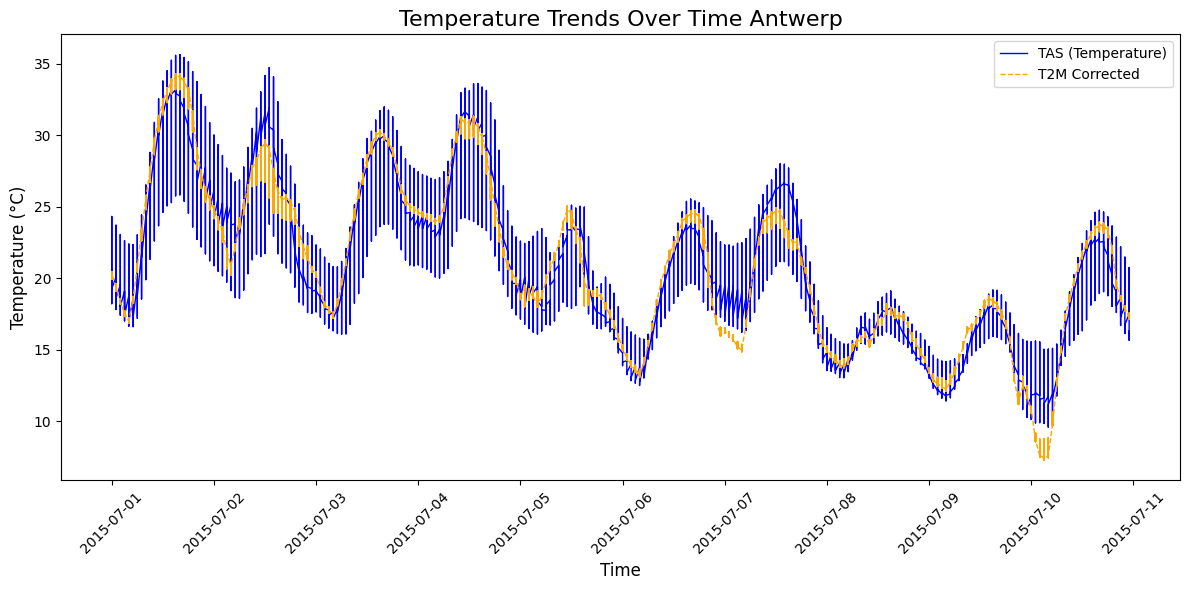

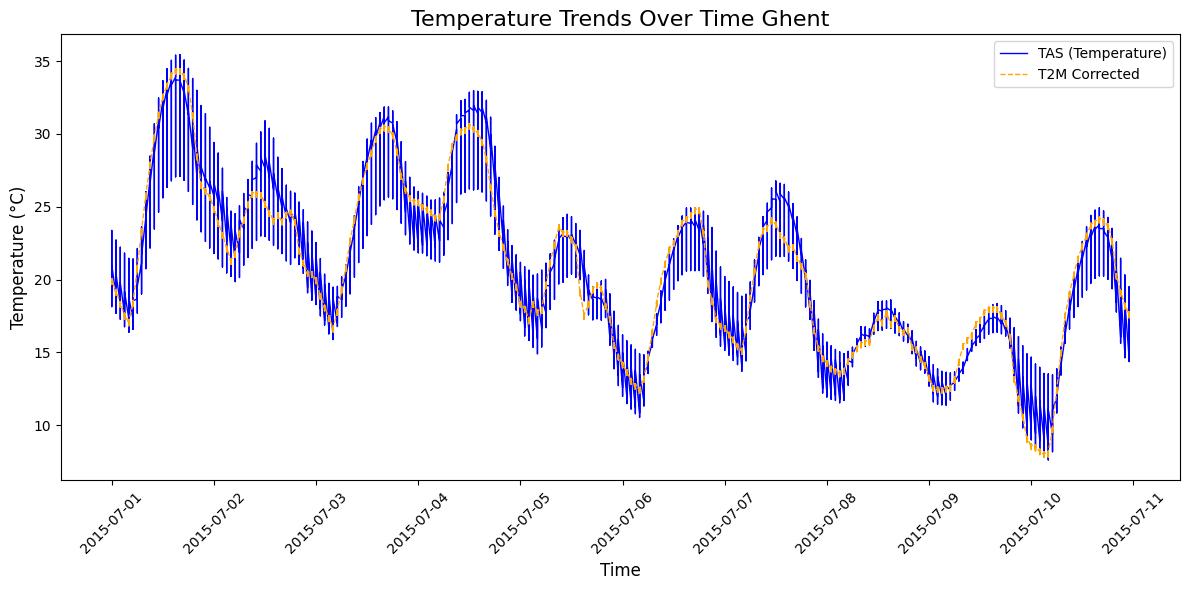

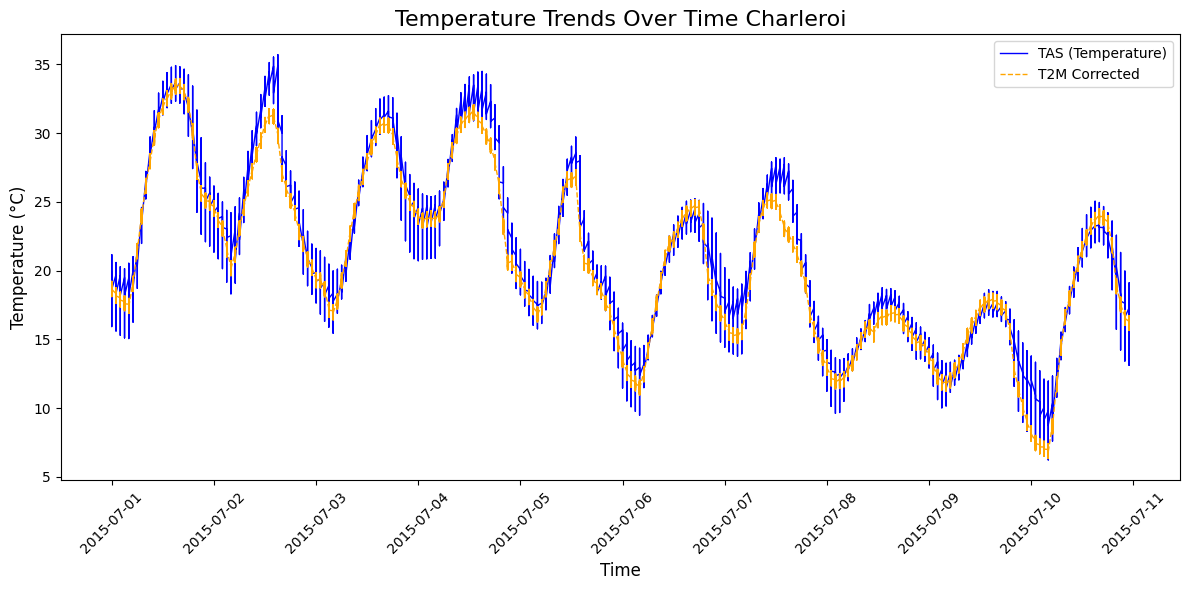

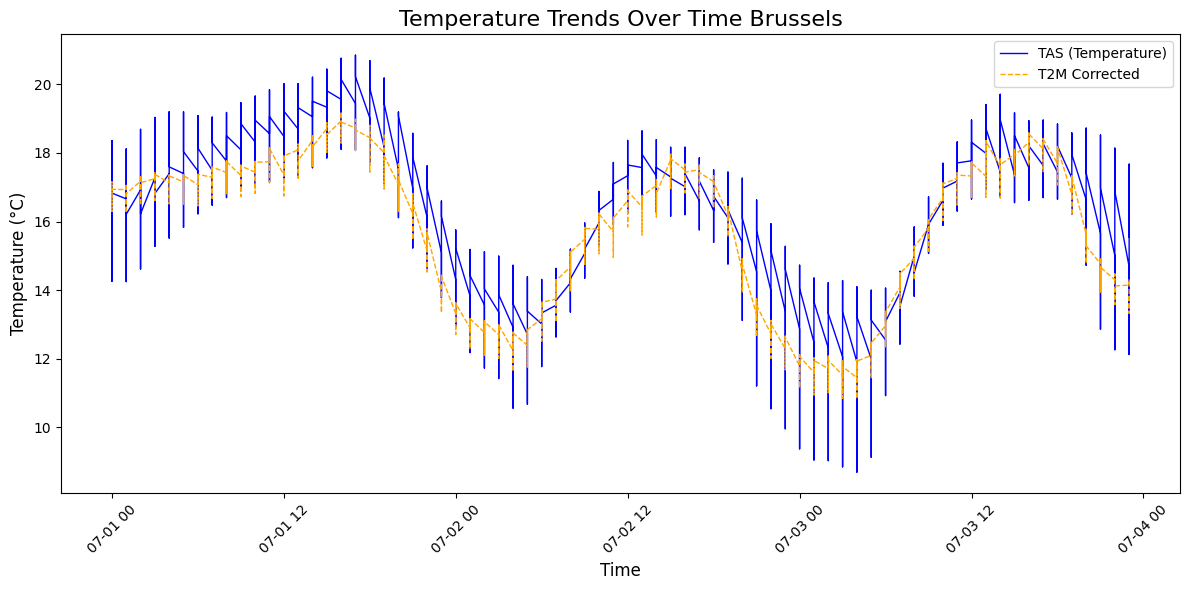

In [24]:
plot_tem_over_time(urbclim_and_feature_files['Antwerp'],'Antwerp')
plot_tem_over_time(urbclim_and_feature_files['Ghent'],'Ghent')
plot_tem_over_time(urbclim_and_feature_files['Charleroi'],'Charleroi')
plot_tem_over_time(all_variables,'Brussels')

In [25]:
def plot_y(df, model_name):
  plt.figure(figsize=(10, 8))
  plt.scatter(df['x'], df['y'], c=df['tas'], cmap='viridis', s=1, vmin = 15, vmax = 21)  # 使用 'viridis' 色彩映射
  plt.colorbar(label='Temperature (tas)')
  plt.xlabel('Longitude (x)')
  plt.ylabel('Latitude (y)')
  plt.title(f'Geographical Distribution of Temperature - {model_name}')
  plt.show()

In [26]:
urbclim_true_value = all_variables[['y','x','time','tas']]
print(urbclim_true_value)

                 y         x                time        tas
0        50.700043  4.207803 2016-07-01 00:00:00  16.676508
1        50.700110  4.209215 2016-07-01 00:00:00  15.752405
2        50.700184  4.210626 2016-07-01 00:00:00  15.443781
3        50.700256  4.212038 2016-07-01 00:00:00  15.520929
4        50.700325  4.213450 2016-07-01 00:00:00  15.409143
...            ...       ...                 ...        ...
6519379  50.986958  4.547782 2016-07-03 23:00:00  14.431055
6519380  50.987026  4.549203 2016-07-03 23:00:00  14.298456
6519381  50.987090  4.550624 2016-07-03 23:00:00  15.202051
6519382  50.987160  4.552045 2016-07-03 23:00:00  14.031366
6519383  50.987225  4.553465 2016-07-03 23:00:00  15.548120

[6519384 rows x 4 columns]


                 y         x                time        tas
1086564  50.700043  4.207803 2016-07-01 12:00:00  18.486353
1086565  50.700110  4.209215 2016-07-01 12:00:00  18.522211
1086566  50.700184  4.210626 2016-07-01 12:00:00  18.481592
1086567  50.700256  4.212038 2016-07-01 12:00:00  18.428247
1086568  50.700325  4.213450 2016-07-01 12:00:00  18.397882
...            ...       ...                 ...        ...
1177106  50.986958  4.547782 2016-07-01 12:00:00  19.203668
1177107  50.987026  4.549203 2016-07-01 12:00:00  19.250665
1177108  50.987090  4.550624 2016-07-01 12:00:00  19.360162
1177109  50.987160  4.552045 2016-07-01 12:00:00  19.243463
1177110  50.987225  4.553465 2016-07-01 12:00:00  19.221399

[90547 rows x 4 columns]
tas min:  17.265863037109398
tas max:  20.0244079589844


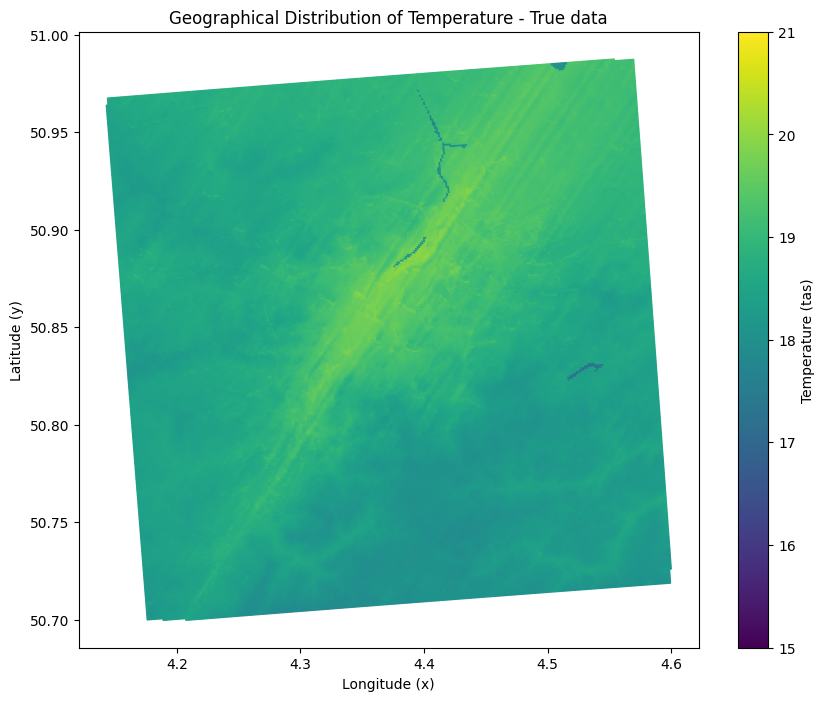

In [27]:
# first_timestamp_true = urbclim_true_value[(urbclim_true_value['time']=="2016-07-01 00:00:00") | (urbclim_true_value['time']=="2016-07-01")]
first_timestamp_true = urbclim_true_value[(urbclim_true_value['time']=="2016-07-01 12:00:00")]
print(first_timestamp_true)
tas_min = first_timestamp_true['tas'].min()
tas_max = first_timestamp_true['tas'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(first_timestamp_true, 'True data')


In [28]:
linear_model = LinearRegression()
# X_train = X_train.drop(columns = ['Unnamed: 0'])
linear_model.fit(X_train, y_train)
# X_test = X_test.drop(columns = ['hour'])

# Predict y
y_pred_lr = linear_model.predict(X_test)
y_pred_lr = pd.DataFrame(y_pred_lr, columns=['residue'])
print(y_pred_lr)

          residue
0        0.882200
1        0.815513
2        0.571591
3        0.500911
4        0.517398
...           ...
6519379  0.280311
6519380  0.042917
6519381  0.527741
6519382  0.444862
6519383  0.071069

[6519384 rows x 1 columns]


In [29]:
y_pred_lr[['y','x','time']] = all_variables[['y','x','time']]
y_test[['y','x','time']] = all_variables[['y','x','time']]

y_pred_lr_day = y_pred_lr[(y_pred_lr['time'].dt.hour >= 6) & (y_pred_lr['time'].dt.hour < 18)]
y_pred_lr_night = y_pred_lr[(y_pred_lr['time'].dt.hour < 6) | (y_pred_lr['time'].dt.hour >= 18)]
y_test_day = y_test[(y_test['time'].dt.hour >= 6) & (y_test['time'].dt.hour < 18)]
y_test_night = y_test[(y_test['time'].dt.hour < 6) | (y_test['time'].dt.hour >= 18)]

print(y_pred_lr_day)
print(y_pred_lr_night)
print(y_test_day)
print(y_test_night)




          residue          y         x                time
543282  -0.128585  50.700043  4.207803 2016-07-01 06:00:00
543283  -0.195272  50.700110  4.209215 2016-07-01 06:00:00
543284  -0.439194  50.700184  4.210626 2016-07-01 06:00:00
543285  -0.509874  50.700256  4.212038 2016-07-01 06:00:00
543286  -0.493387  50.700325  4.213450 2016-07-01 06:00:00
...           ...        ...       ...                 ...
5976097  0.156227  50.986958  4.547782 2016-07-03 17:00:00
5976098 -0.081168  50.987026  4.549203 2016-07-03 17:00:00
5976099  0.403657  50.987090  4.550624 2016-07-03 17:00:00
5976100  0.320778  50.987160  4.552045 2016-07-03 17:00:00
5976101 -0.053015  50.987225  4.553465 2016-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        0.882200  50.700043  4.207803 2016-07-01 00:00:00
1        0.815513  50.700110  4.209215 2016-07-01 00:00:00
2        0.571591  50.700184  4.210626 2016-07-01 00:00:00
3        0.500911  50.700256

In [30]:
# compute the errors
# compute MAE (Mean Absolute Error)
def calculate_errors(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    
    # compute MSE (Mean Squared Error)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # compute RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    # compute R² (R-squared)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared (R²): {r2}")



In [31]:
print("Errors:")
calculate_errors(y_test['residue'], y_pred_lr['residue'])
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_lr_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_lr_night['residue'])

Errors:
Mean Absolute Error (MAE): 0.8649056592017936
Mean Squared Error (MSE): 1.2505904662090874
Root Mean Squared Error (RMSE): 1.1182980220894103
R-squared (R²): -0.5402471969559903
Errors during day:
Mean Absolute Error (MAE): 0.8408380577284018
Mean Squared Error (MSE): 1.1589729236327762
Root Mean Squared Error (RMSE): 1.0765560476040141
R-squared (R²): -1.475445248180785
Errors during night:
Mean Absolute Error (MAE): 0.8889732606751853
Mean Squared Error (MSE): 1.3422080087854023
Root Mean Squared Error (RMSE): 1.1585370122639165
R-squared (R²): -0.1677087578898182


In [32]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_lr = pd.DataFrame()

urbclim_pred_lr['tas'] = y_pred_lr['residue'] + all_variables['t2m_corrected']
urbclim_pred_lr[['y','x','time']] = all_variables[['y','x','time']]

print(urbclim_pred_lr)

               tas          y         x                time
0        17.792006  50.700043  4.207803 2016-07-01 00:00:00
1        17.726110  50.700110  4.209215 2016-07-01 00:00:00
2        17.489705  50.700184  4.210626 2016-07-01 00:00:00
3        17.422970  50.700256  4.212038 2016-07-01 00:00:00
4        17.426434  50.700325  4.213450 2016-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  14.115903  50.986958  4.547782 2016-07-03 23:00:00
6519380  13.887384  50.987026  4.549203 2016-07-03 23:00:00
6519381  14.372357  50.987090  4.550624 2016-07-03 23:00:00
6519382  14.284608  50.987160  4.552045 2016-07-03 23:00:00
6519383  13.912102  50.987225  4.553465 2016-07-03 23:00:00

[6519384 rows x 4 columns]


               tas          y         x                time
1086564  17.652965  50.700043  4.207803 2016-07-01 12:00:00
1086565  17.587070  50.700110  4.209215 2016-07-01 12:00:00
1086566  17.350664  50.700184  4.210626 2016-07-01 12:00:00
1086567  17.283929  50.700256  4.212038 2016-07-01 12:00:00
1086568  17.287394  50.700325  4.213450 2016-07-01 12:00:00
...            ...        ...       ...                 ...
1177106  18.458491  50.986958  4.547782 2016-07-01 12:00:00
1177107  18.229973  50.987026  4.549203 2016-07-01 12:00:00
1177108  18.714946  50.987090  4.550624 2016-07-01 12:00:00
1177109  18.627197  50.987160  4.552045 2016-07-01 12:00:00
1177110  18.254691  50.987225  4.553465 2016-07-01 12:00:00

[90547 rows x 4 columns]
tas min:  17.09739891827668
tas max:  22.42699322202531


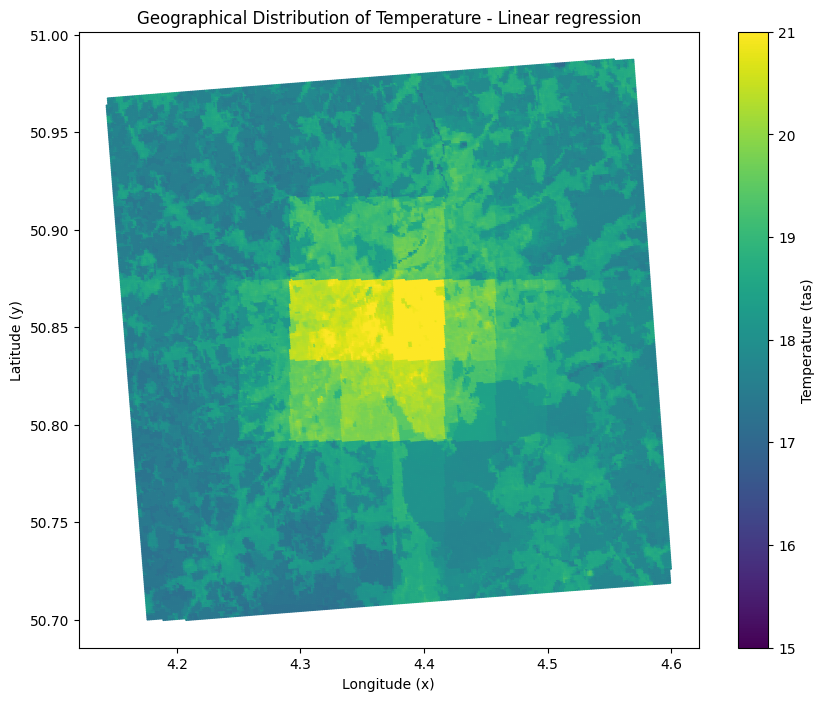

In [33]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2015-07-01 00:00:00") | (urbclim_pred['time']=="2015-07-01")]
first_stamp_data_lr = urbclim_pred_lr[(urbclim_pred_lr['time']=="2016-07-01 12:00:00")]
print(first_stamp_data_lr)
tas_min_lr = first_stamp_data_lr['tas'].min()
tas_max_lr = first_stamp_data_lr['tas'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_y(first_stamp_data_lr, 'Linear regression')

In [34]:
#use ANN model to predict the temp
from sklearn.neural_network import MLPRegressor


ann_model = MLPRegressor(hidden_layer_sizes=(4, 2),
                                activation='relu',
                                solver='adam',
                                max_iter=100,
                                random_state=45,
                                early_stopping=True,
                                validation_fraction=0.1,
                                n_iter_no_change=20,
                                alpha=0.03)

# y_train = y_train.ravel()
ann_model.fit(X_train, y_train)

y_pred_mlp = ann_model.predict(X_test)
y_pred_mlp = pd.DataFrame(y_pred_mlp, columns=['residue'])
print(y_pred_mlp)

/Users/wangy/Documents/MACS/Thesis/thesis_code/thesis_featurevisual/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


          residue
0        0.352818
1        0.352818
2        0.352818
3        0.352818
4        0.352818
...           ...
6519379  0.352818
6519380  0.352818
6519381  0.352818
6519382  0.352818
6519383  0.352818

[6519384 rows x 1 columns]


In [35]:
y_pred_mlp[['y','x','time']] = all_variables[['y','x','time']]


y_pred_mlp_day = y_pred_mlp[(y_pred_mlp['time'].dt.hour >= 6) & (y_pred_mlp['time'].dt.hour < 18)]
y_pred_mlp_night = y_pred_mlp[(y_pred_mlp['time'].dt.hour < 6) | (y_pred_mlp['time'].dt.hour >= 18)]

print(y_pred_mlp_day)
print(y_pred_mlp_night)


          residue          y         x                time
543282   0.352818  50.700043  4.207803 2016-07-01 06:00:00
543283   0.352818  50.700110  4.209215 2016-07-01 06:00:00
543284   0.352818  50.700184  4.210626 2016-07-01 06:00:00
543285   0.352818  50.700256  4.212038 2016-07-01 06:00:00
543286   0.352818  50.700325  4.213450 2016-07-01 06:00:00
...           ...        ...       ...                 ...
5976097  0.352818  50.986958  4.547782 2016-07-03 17:00:00
5976098  0.352818  50.987026  4.549203 2016-07-03 17:00:00
5976099  0.352818  50.987090  4.550624 2016-07-03 17:00:00
5976100  0.352818  50.987160  4.552045 2016-07-03 17:00:00
5976101  0.352818  50.987225  4.553465 2016-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        0.352818  50.700043  4.207803 2016-07-01 00:00:00
1        0.352818  50.700110  4.209215 2016-07-01 00:00:00
2        0.352818  50.700184  4.210626 2016-07-01 00:00:00
3        0.352818  50.700256

In [36]:
calculate_errors(y_test['residue'], y_pred_mlp['residue'])

Mean Absolute Error (MAE): 0.7246262778113504
Mean Squared Error (MSE): 0.8156667428205395
Root Mean Squared Error (RMSE): 0.9031427034641533
R-squared (R²): -0.004588191118923612


In [37]:
print("Errors during day:")
calculate_errors(y_test_day['residue'], y_pred_mlp_day['residue'])
print("Errors during night:")
calculate_errors(y_test_night['residue'], y_pred_mlp_night['residue'])

Errors during day:
Mean Absolute Error (MAE): 0.5861469741651818
Mean Squared Error (MSE): 0.4682136606104031
Root Mean Squared Error (RMSE): 0.6842613978666363
R-squared (R²): -5.552990692425652e-05
Errors during night:
Mean Absolute Error (MAE): 0.8631055814575196
Mean Squared Error (MSE): 1.1631198250306738
Root Mean Squared Error (RMSE): 1.0784803313137767
R-squared (R²): -0.011903667146679009


In [38]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_mlp = pd.DataFrame()

urbclim_pred_mlp['tas'] = y_pred_mlp['residue'] + all_variables['t2m_corrected']
urbclim_pred_mlp[['y','x','time']] = all_variables[['y','x','time']]

print(urbclim_pred_mlp)



               tas          y         x                time
0        17.262623  50.700043  4.207803 2016-07-01 00:00:00
1        17.263415  50.700110  4.209215 2016-07-01 00:00:00
2        17.270931  50.700184  4.210626 2016-07-01 00:00:00
3        17.274876  50.700256  4.212038 2016-07-01 00:00:00
4        17.261854  50.700325  4.213450 2016-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  14.188409  50.986958  4.547782 2016-07-03 23:00:00
6519380  14.197286  50.987026  4.549203 2016-07-03 23:00:00
6519381  14.197434  50.987090  4.550624 2016-07-03 23:00:00
6519382  14.192564  50.987160  4.552045 2016-07-03 23:00:00
6519383  14.193851  50.987225  4.553465 2016-07-03 23:00:00

[6519384 rows x 4 columns]


tas min:  17.101857758102145
tas max:  18.292178043803577


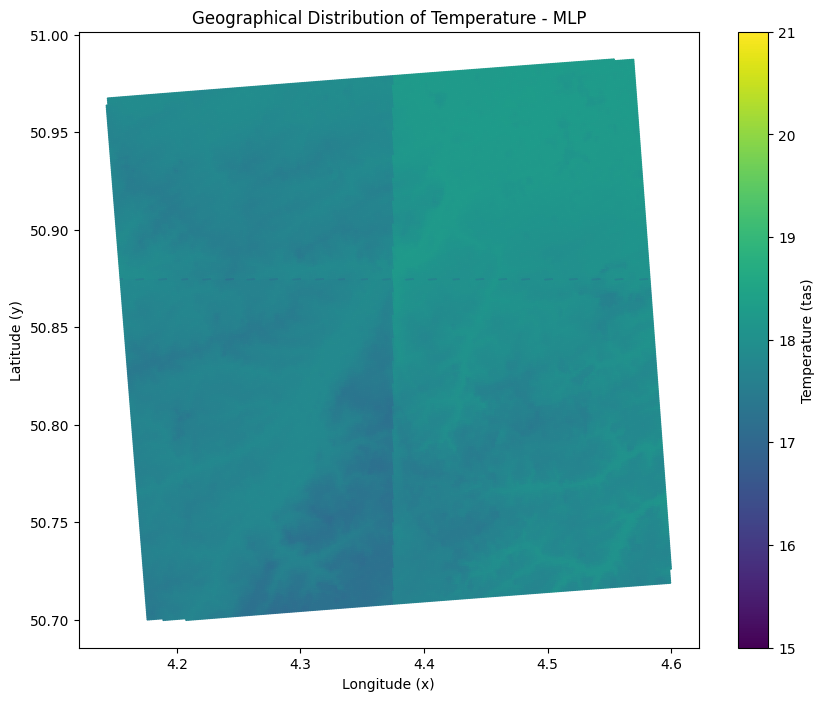

In [39]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2016-07-01 12:00:00") | (urbclim_pred['time']=="2016-07-01")]
first_stamp_data_mlp = urbclim_pred_mlp[(urbclim_pred_mlp['time']=="2016-07-01 12:00:00")]
tas_min_mlp = first_stamp_data_mlp['tas'].min()
tas_max_mlp = first_stamp_data_mlp['tas'].max()
print("tas min: " ,tas_min_mlp)
print("tas max: " ,tas_max_mlp)
plot_y(first_stamp_data_mlp, 'MLP')

In [40]:
# calculate the error matric for corrected era5 with urbclim for test set
urbclim_true = all_variables['tas']
era5_true = all_variables['t2m_corrected']
calculate_errors(urbclim_true, era5_true)

Mean Absolute Error (MAE): 0.7576162938982443
Mean Squared Error (MSE): 0.8970783334185717
Root Mean Squared Error (RMSE): 0.9471421928193103
R-squared (R²): 0.8508075798024953


In [41]:
urbclim_true_day = all_variables[(all_variables['time'].dt.hour >= 6) & (all_variables['time'].dt.hour < 18)][['tas']]
urbclim_true_night =  all_variables[(all_variables['time'].dt.hour < 6) | (all_variables['time'].dt.hour >= 18)][['tas']]
era5_true_day = all_variables[(all_variables['time'].dt.hour >= 6) & (all_variables['time'].dt.hour < 18)][['t2m_corrected']]
era5_true_night = all_variables[(all_variables['time'].dt.hour < 6) | (all_variables['time'].dt.hour >= 18)][['t2m_corrected']]
print("Errors during day:")
calculate_errors(urbclim_true_day['tas'], era5_true_day['t2m_corrected'])
print("Errors during night:")
calculate_errors(urbclim_true_night['tas'], era5_true_night['t2m_corrected'])


Errors during day:
Mean Absolute Error (MAE): 0.6405459315080486
Mean Squared Error (MSE): 0.5890962043613887
Root Mean Squared Error (RMSE): 0.767526028458572
R-squared (R²): 0.8424822132543369
Errors during night:
Mean Absolute Error (MAE): 0.8746866562884401
Mean Squared Error (MSE): 1.205060462475756
Root Mean Squared Error (RMSE): 1.0977524595626083
R-squared (R²): 0.7914095731224955


tas min:  16.749039837409157
tas max:  17.93936012311059


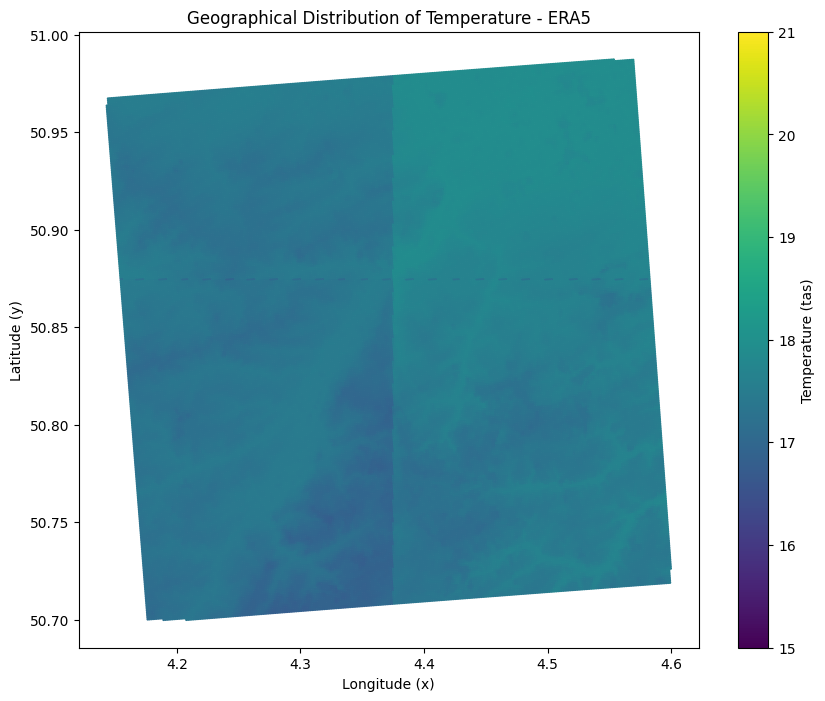

In [42]:
ERA5_plot = all_variables[(all_variables['time'] == "2016-07-01 12:00:00")][['t2m_corrected','x','y']]
ERA5_plot = ERA5_plot.rename(columns={'t2m_corrected': 'tas'})
tas_min = ERA5_plot['tas'].min()
tas_max = ERA5_plot['tas'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(ERA5_plot, 'ERA5')

